In [1]:
import os
# import pandas as pd 
import polars as pl
# import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
figformat = 'png'
dpi = 300
statarg = 'single'
OutputDir = f'./data/4_CellCoverage'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
FeatureDir = './data/1_FeaturesImages_meanstd_PerPlate'

In [3]:
statmet = 'SingleCell'
filenames = ['HT29', 'HCT116']
trt_type = 'dmso'

In [4]:
df = pl.read_parquet(f'{FeatureDir}/{statmet}/{filenames[0]}.parquet')

In [5]:
df.select(pl.col('Metadata_cmpd_target')).to_series().unique()

Metadata_cmpd_target
str
"""JAK"""
"""CDK"""
"""Others"""
"""DNA topoisomerase 2-alpha & DN…"
"""pan protein inhibitor"""
…
"""EGFR,HER2"""
"""PI3K"""
"""Autophagy,DNA-PK,mTOR,PI3K"""


In [6]:
df_dmso = df.filter(pl.col('Metadata_cmpd_cmpdname')=='dmso')

In [7]:
df_dmso.head()

Cytoplasm_ImageNumber,Cytoplasm_ObjectNumber,Cytoplasm_Metadata_AcqID,Metadata_Barcode,Metadata_Site,Metadata_Well,Cytoplasm_FileName_CONC,Cytoplasm_FileName_HOECHST,Cytoplasm_FileName_MITO,Cytoplasm_FileName_PHAandWGA,Cytoplasm_FileName_SYTO,Cytoplasm_PathName_CONC,Cytoplasm_PathName_HOECHST,Cytoplasm_PathName_MITO,Cytoplasm_PathName_PHAandWGA,Cytoplasm_PathName_SYTO,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_BoundingBoxArea,Cytoplasm_AreaShape_BoundingBoxMaximum_X,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Cytoplasm_AreaShape_BoundingBoxMinimum_X,Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Cytoplasm_AreaShape_Center_X,Cytoplasm_AreaShape_Center_Y,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_ConvexArea,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_EquivalentDiameter,Cytoplasm_AreaShape_EulerNumber,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,…,Cells_RadialDistribution_ZernikePhase_SYTO_3_1,Cells_RadialDistribution_ZernikePhase_SYTO_3_3,Cells_RadialDistribution_ZernikePhase_SYTO_4_0,Cells_RadialDistribution_ZernikePhase_SYTO_4_2,Cells_RadialDistribution_ZernikePhase_SYTO_4_4,Cells_RadialDistribution_ZernikePhase_SYTO_5_1,Cells_RadialDistribution_ZernikePhase_SYTO_5_3,Cells_RadialDistribution_ZernikePhase_SYTO_5_5,Cells_RadialDistribution_ZernikePhase_SYTO_6_0,Cells_RadialDistribution_ZernikePhase_SYTO_6_2,Cells_RadialDistribution_ZernikePhase_SYTO_6_4,Cells_RadialDistribution_ZernikePhase_SYTO_6_6,Cells_RadialDistribution_ZernikePhase_SYTO_7_1,Cells_RadialDistribution_ZernikePhase_SYTO_7_3,Cells_RadialDistribution_ZernikePhase_SYTO_7_5,Cells_RadialDistribution_ZernikePhase_SYTO_7_7,Cells_RadialDistribution_ZernikePhase_SYTO_8_0,Cells_RadialDistribution_ZernikePhase_SYTO_8_2,Cells_RadialDistribution_ZernikePhase_SYTO_8_4,Cells_RadialDistribution_ZernikePhase_SYTO_8_6,Cells_RadialDistribution_ZernikePhase_SYTO_8_8,Cells_RadialDistribution_ZernikePhase_SYTO_9_1,Cells_RadialDistribution_ZernikePhase_SYTO_9_3,Cells_RadialDistribution_ZernikePhase_SYTO_9_5,Cells_RadialDistribution_ZernikePhase_SYTO_9_7,Cells_RadialDistribution_ZernikePhase_SYTO_9_9,Metadata_cmpd_image_id,Metadata_cmpd_cp_id,Metadata_cmpd_barcode,Metadata_cmpd_plate_well,Metadata_cmpd_cmpdname,Metadata_cmpd_pert_type,Metadata_cmpd_target,Metadata_cmpd_pathway,Metadata_cmpd_target_type,Metadata_cmpd_cell_line,Metadata_PlateWell
i32,i32,i32,str,i32,str,str,str,str,str,str,str,str,str,str,str,i32,i32,i32,i32,i32,i32,f32,f32,f32,i32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i64,str,str,str,str,str,str,str,str,str
1,1,4191,"""PB000142""",0,"""N04""","""Well-N04-z0-CONC.ome.tiff""","""Well-N04-z0-HOECHST.ome.tiff""","""Well-N04-z0-MITO.ome.tiff""","""Well-N04-z0-PHAandWGA.ome.tiff""","""Well-N04-z0-SYTO.ome.tiff""","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…",3752,4891,536,337,463,270,497.640472,303.305969,1.124988,3831,0.437203,69.117256,1,0.767123,0.888898,73.145081,74.040527,32.0,11.400725,10.0,65.898445,…,2.874434,3.049932,-1.570796,-1.82453,-0.188775,2.973966,-2.869677,1.151401,-1.570796,-2.311358,0.442847,-1.354712,-0.350877,-0.421607,0.205414,1.124477,1.570796,1.151731,0.086862,-2.740131,-1.665544,0.260534,0.402003,0.857256,1.672337,0.500435,4191,5574,"""PB000142""","""PB000142_N04""","""dmso""","""neg_con""","""control""","""dmso""",null,"""HT29""","""PB000142_N04"""
1,2,4191,"""PB000142""",0,"""N04""","""Well-N04-z0-CONC.ome.tiff""","""Well-N04-z0-HOECHST.ome.tiff""","""Well-N04-z0-MITO.ome.tiff""","""Well-N04-z0-PHAandWGA.ome.tiff""","""Well-N04-z0-SYTO.ome.tiff""","""/share/mikro2/nikon/spher

In [8]:
df.select(pl.col('Metadata_Site')).to_series().unique()

Metadata_Site
i32
0
1
2
3
4
…
8
9
10


In [9]:


def calc_numcells(df):
    max_columns=[pl.col('Cytoplasm_ObjectNumber'), pl.col('Nuclei_ObjectNumber')]
    sum_columns=[pl.col('Cytoplasm_AreaShape_Area')]
    mean_columns = max_columns + sum_columns
    df_out = pl.DataFrame()
    df = df.with_columns(pl.col('Cytoplasm_ObjectNumber').cast(pl.Float64))
    df_max_columns=set(list(df.select(max_columns).columns))
    df_sum_columns=set(list(df.select(sum_columns).columns))
    group_by_columns=['Metadata_PlateWell','Metadata_Site']
    other_columns=set(list(df.columns))-df_max_columns-df_sum_columns-set(group_by_columns)
    group_by_aggregates=[
    *[pl.max(x) for x in list(df_max_columns)],
    # *[pl.std(x).alias(f"{x}_std") for x in list(df_max_columns)],
    *[pl.sum(x) for x in list(df_sum_columns)],
    *[pl.first(x) for x in list(other_columns)]
    ]
    df=df.group_by(group_by_columns).agg(group_by_aggregates)

    #didn't need this, ffs......
    # df = df.drop(['Metadata_Well', 'Metadata_PlateWell', 'Metadata_Barcode'])
    # df_mean_columns=set(list(df.select(mean_columns).columns))
    # group_by_columns=['Metadata_Site']
    # other_columns=set(list(df.columns))-df_mean_columns-set(group_by_columns)
    # group_by_aggregates=[
    # *[pl.max(x) for x in list(df_mean_columns)],
    # *[pl.std(x).alias(f"{x}_std") for x in list(df_mean_columns)],
    # *[pl.first(x) for x in list(other_columns)]
    # ]
    # df=df.group_by(group_by_columns).agg(group_by_aggregates)

    df_out = df
    return df_out

In [10]:
df2 = df_dmso.select(pl.col(['Metadata_PlateWell', 'Metadata_Well', 'Metadata_Barcode', 'Metadata_Site', 'Cytoplasm_AreaShape_Area', 'Cytoplasm_ObjectNumber', 'Nuclei_ObjectNumber']))

In [11]:
df2.head()

Metadata_PlateWell,Metadata_Well,Metadata_Barcode,Metadata_Site,Cytoplasm_AreaShape_Area,Cytoplasm_ObjectNumber,Nuclei_ObjectNumber
str,str,str,i32,i32,i32,f64
"""PB000142_N04""","""N04""","""PB000142""",0,3752,1,1.0
"""PB000142_N04""","""N04""","""PB000142""",0,7599,2,2.0
"""PB000142_N04""","""N04""","""PB000142""",0,3182,3,4.0
"""PB000142_N04""","""N04""","""PB000142""",0,4399,4,5.0
"""PB000142_N04""","""N04""","""PB000142""",0,3275,5,4.5


In [12]:
df3 = calc_numcells(df2)
df3 = df3.sort(pl.col('Metadata_Site'))

In [13]:
df3.head()

Metadata_PlateWell,Metadata_Site,Nuclei_ObjectNumber,Cytoplasm_ObjectNumber,Cytoplasm_AreaShape_Area,Metadata_Barcode,Metadata_Well
str,i32,f64,f64,i32,str,str
"""PB000139_G14""",0,23.0,22.0,76764,"""PB000139""","""G14"""
"""PB000142_F20""",0,18.0,14.0,49908,"""PB000142""","""F20"""
"""PB000141_L07""",0,24.0,21.0,69107,"""PB000141""","""L07"""
"""PB000142_G13""",0,7.0,7.0,30739,"""PB000142""","""G13"""
"""PB000139_I17""",0,23.0,22.0,76101,"""PB000139""","""I17"""


/tmp/ipykernel_7144/255121214.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df3['Metadata_Site'].unique())


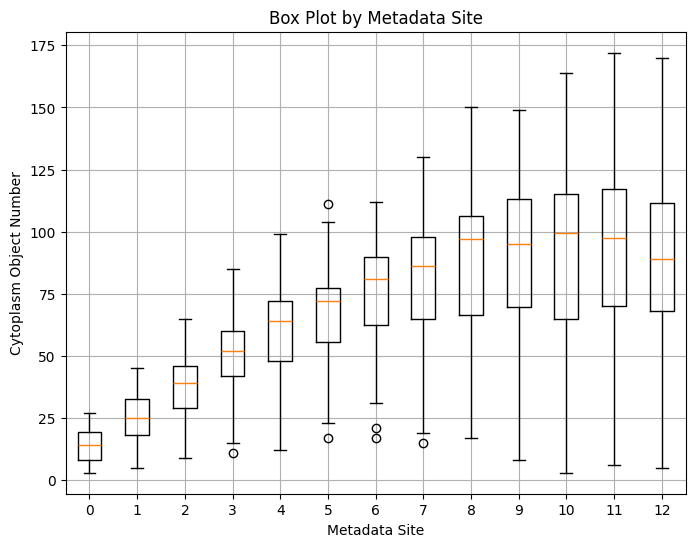

In [14]:
data = [df3.filter(pl.col('Metadata_Site') == site)['Cytoplasm_ObjectNumber'].to_list() for site in df3['Metadata_Site'].unique()]

# Create a box plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=df3['Metadata_Site'].unique())

# Customize the plot
plt.xlabel('Metadata Site')
plt.ylabel('Cytoplasm Object Number')
plt.title('Box Plot by Metadata Site')
plt.grid(True)

# Show the plot
plt.show()

/tmp/ipykernel_7144/3808145924.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df3['Metadata_Site'].unique())


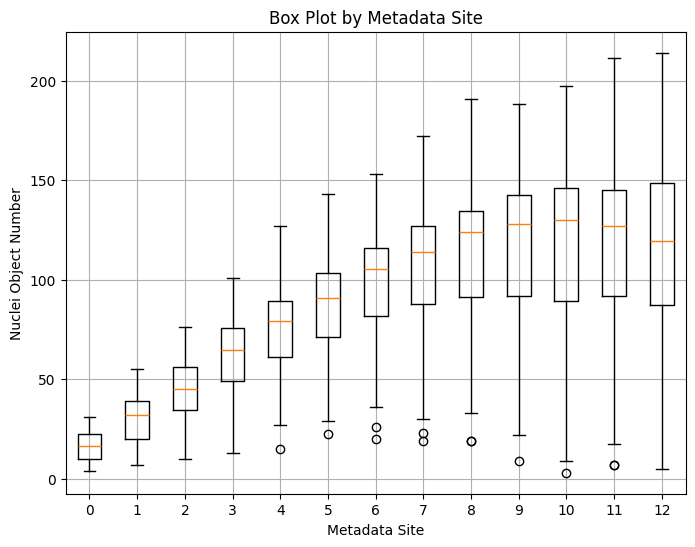

In [15]:
data = [df3.filter(pl.col('Metadata_Site') == site)['Nuclei_ObjectNumber'].to_list() for site in df3['Metadata_Site'].unique()]

# Create a box plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=df3['Metadata_Site'].unique())

# Customize the plot
plt.xlabel('Metadata Site')
plt.ylabel('Nuclei Object Number')
plt.title('Box Plot by Metadata Site')
plt.grid(True)

# Show the plot
plt.show()

/tmp/ipykernel_7144/4245841051.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df3['Metadata_Site'].unique())


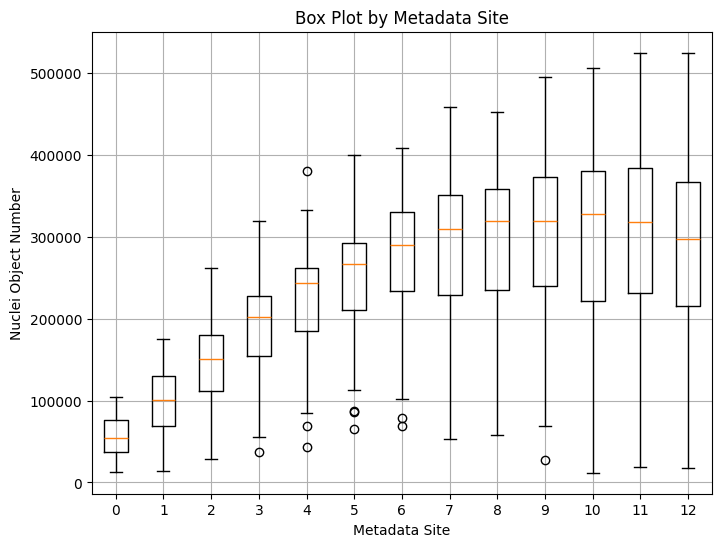

In [16]:
data = [df3.filter(pl.col('Metadata_Site') == site)['Cytoplasm_AreaShape_Area'].to_list() for site in df3['Metadata_Site'].unique()]

# Create a box plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=df3['Metadata_Site'].unique())

# Customize the plot
plt.xlabel('Metadata Site')
plt.ylabel('Nuclei Object Number')
plt.title('Box Plot by Metadata Site')
plt.grid(True)

# Show the plot
plt.show()